In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import pandas as pd
import gzip
import json

class SharpWaveComponentPlotter:
    """
    Class for loading and organizing Sharp Wave Ripple (SWR) data.
    
    The class organizes data in a hierarchical structure:
    - dataset
        - session_id
            - probe_id
                - event_type (karlsson_detector_events, gamma_band_events, movement_artifacts)
    """
    
    def __init__(self, base_path):
        """
        Initialize with the base path where data is stored.
        
        Parameters:
        -----------
        base_path : str
            Path to the directory containing the datasets
        """
        self.base_path = base_path
        self.data = {}
        self.event_types = {
            'karlsson_detector_events',
            'gamma_band_events',
            'movement_artifacts'
        }
    
    def _parse_filename(self, filepath):
        """
        Parse filename to extract components (probe_id, channel_id, event_type).
        
        Parameters:
        -----------
        filepath : str
            Path to the file
            
        Returns:
        --------
        tuple : (probe_id, channel_id, event_type)
        """
        filename = os.path.basename(filepath)
        
        # Extract probe ID
        probe_match = re.search(r'probe_(\d+)', filename)
        probe_id = probe_match.group(1) if probe_match else None
        
        # Extract channel ID
        channel_match = re.search(r'channel_([^_]+)', filename)
        channel_id = channel_match.group(1) if channel_match else None
        
        # Special case for channelsrawInd
        if channel_id == 'channelsrawInd':
            channel_raw_match = re.search(r'channelsrawInd_(\d+)', filename)
            if channel_raw_match:
                channel_id = f"channelsrawInd_{channel_raw_match.group(1)}"
        
        # Extract event type
        event_type = None
        for et in self.event_types:
            if et in filename:
                event_type = et
                break
                
        # Special case for movement_artifacts
        if 'movement_artifacts' in filename:
            event_type = 'movement_artifacts'
            
        return probe_id, channel_id, event_type
    
    def load_data(self, dataset_name, session_ids=None):
        """
        Load data from the specified dataset and session IDs.
        
        Parameters:
        -----------
        dataset_name : str
            Name of the dataset directory
        session_ids : list, optional
            List of session IDs to load. If None, all sessions are loaded.
        
        Returns:
        --------
        self : for method chaining
        """
        dataset_path = os.path.join(self.base_path, dataset_name)
        
        if not os.path.exists(dataset_path):
            raise ValueError(f"Dataset path does not exist: {dataset_path}")
        
        # Initialize dataset in the data structure if it doesn't exist
        if dataset_name not in self.data:
            self.data[dataset_name] = {}
            
        # Get all session directories if session_ids is None
        if session_ids is None:
            session_dirs = glob.glob(os.path.join(dataset_path, "swrs_session_*"))
            session_ids = [os.path.basename(d).split('_')[-1] for d in session_dirs]
        
        # Loop through each session
        for session_id in tqdm(session_ids, desc="Loading sessions"):
            session_path = os.path.join(dataset_path, f"swrs_session_{session_id}")
            
            if not os.path.exists(session_path):
                print(f"Warning: Session path does not exist: {session_path}")
                continue
            
            # Initialize session in the data structure
            if session_id not in self.data[dataset_name]:
                self.data[dataset_name][session_id] = {}
            
            # Find all CSV files in the session directory
            csv_files = glob.glob(os.path.join(session_path, "*.csv*"))
            
            # Process each CSV file
            for csv_file in csv_files:
                try:
                    # Parse filename to get components
                    probe_id, channel_id, event_type = self._parse_filename(csv_file)
                    
                    if not all([probe_id, event_type]):
                        print(f"Warning: Could not parse components from: {csv_file}")
                        continue
                    
                    # Initialize probe in the data structure
                    if probe_id not in self.data[dataset_name][session_id]:
                        self.data[dataset_name][session_id][probe_id] = {}
                    
                    # Load CSV with gzip compression
                    df = pd.read_csv(csv_file, compression="gzip")
                    
                    # Store in the data structure
                    self.data[dataset_name][session_id][probe_id][event_type] = df
                    
                    print(f"Loaded: {csv_file}")
                except Exception as e:
                    print(f"Error processing {csv_file}: {str(e)}")
                    continue
        
        return self

    def get_data(self, dataset_name=None, session_id=None, probe_id=None, event_type=None):
        """
        Retrieve data based on specified parameters.
        
        Parameters:
        -----------
        dataset_name : str, optional
            Name of the dataset
        session_id : str, optional
            Session ID
        probe_id : str, optional
            Probe ID
        event_type : str, optional
            Event type
        
        Returns:
        --------
        pd.DataFrame or dict
            Data that matches the specified parameters
        """
        # Start with the full data dict
        result = self.data
        
        # Filter by dataset_name
        if dataset_name is not None:
            if dataset_name not in result:
                raise ValueError(f"Dataset '{dataset_name}' not found")
            result = result[dataset_name]
            
            # Filter by session_id
            if session_id is not None:
                if session_id not in result:
                    raise ValueError(f"Session '{session_id}' not found in dataset '{dataset_name}'")
                result = result[session_id]
                
                # When probe_id not specified but event_type is
                if probe_id is None and event_type is not None:
                    # Create a list to hold matching dataframes
                    event_dfs = []
                    # Loop through all probes in this session
                    for probe in result.keys():
                        for event in result[probe].keys():
                            if event == event_type:
                                event_dfs.append(result[probe][event])
                    # Return the list of dataframes
                    return event_dfs
                
                # Filter by probe_id
                if probe_id is not None:
                    if probe_id not in result:
                        raise ValueError(f"Probe '{probe_id}' not found in session '{session_id}'")
                    result = result[probe_id]
                    
                    # Filter by event_type
                    if event_type is not None:
                        if event_type not in result:
                            raise ValueError(f"Event type '{event_type}' not found for probe '{probe_id}'")
                        result = result[event_type]
        
        return result

    def plot_swr_events(self, dataset_name, session_ids=None, x_col='max_zscore', y_col='sw_peak_power', 
                        color_by_overlap=True, x_threshold=None, y_threshold=None, alpha=0.7,
                        figsize=(12, 8), title=None, xlabel=None, ylabel=None, legend=True,
                        plot_name=None):
        """
        Create a scatter plot of SWR events (karlsson_detector_events) and store the concatenated data.
        
        Parameters:
        -----------
        dataset_name : str
            Name of the dataset
        session_ids : list or str, optional
            Single session ID or list of session IDs to include. If None, all loaded sessions are used.
        x_col : str, default='max_zscore'
            Column name for x-axis
        y_col : str, default='sw_peak_power'
            Column name for y-axis
        color_by_overlap : bool, default=True
            Whether to color points by their overlap with gamma and movement events
        x_threshold : float or list, optional
            Value(s) for vertical threshold line(s)
        y_threshold : float or list, optional
            Value(s) for horizontal threshold line(s)
        alpha : float, default=0.7
            Transparency of points
        figsize : tuple, default=(12, 8)
            Figure size as (width, height)
        title : str, optional
            Plot title (if None, a default title will be generated)
        xlabel : str, optional
            X-axis label (if None, x_col will be used)
        ylabel : str, optional
            Y-axis label (if None, y_col will be used)
        legend : bool, default=True
            Whether to show the legend
        plot_name : str, optional
            Name to identify this plot in the stored plotlist dictionary.
            If None, a name will be generated based on dataset and session.
            
        Returns:
        --------
        fig, ax : tuple
            Matplotlib figure and axis objects
        """

        
        # Initialize the plotlist if it doesn't exist
        if not hasattr(self, 'plotlist'):
            self.plotlist = {}
        
        # Handle single session ID
        if isinstance(session_ids, str):
            session_ids = [session_ids]
        
        # Get all karlsson events data
        all_dfs = []
        
        if session_ids is None:
            # Get all sessions if none specified
            if dataset_name in self.data:
                session_ids = list(self.data[dataset_name].keys())
            else:
                raise ValueError(f"Dataset '{dataset_name}' not found")
        
        # Collect data from all requested sessions
        for session_id in session_ids:
            event_dfs = self.get_data(dataset_name, session_id, event_type='karlsson_detector_events')
            if event_dfs:  # Add to list if not empty
                all_dfs.extend(event_dfs)
        
        if not all_dfs:
            raise ValueError("No karlsson_detector_events data found for the specified sessions")
        
        # Concatenate all dataframes
        data = pd.concat(all_dfs, ignore_index=True)
        
        # Generate plot name if not provided
        if plot_name is None:
            if len(session_ids) == 1:
                plot_name = f"{dataset_name}_session_{session_ids[0]}_{x_col}_vs_{y_col}"
            else:
                plot_name = f"{dataset_name}_multiple_sessions_{x_col}_vs_{y_col}"
        
        # Store the data in the plotlist
        self.plotlist[plot_name] = {
            'data': data,
            'params': {
                'dataset_name': dataset_name,
                'session_ids': session_ids,
                'x_col': x_col,
                'y_col': y_col,
                'x_threshold': x_threshold,
                'y_threshold': y_threshold
            }
        }
        
        # Create the figure
        fig, ax = plt.subplots(figsize=figsize)
        
        # Determine colors based on overlap
        if color_by_overlap:
            # Create a color map for the four conditions
            colors = []
            for i, row in data.iterrows():
                if row['overlaps_with_gamma'] and row['overlaps_with_movement']:
                    colors.append('brown')  # Both gamma and movement
                elif row['overlaps_with_gamma']:
                    colors.append('purple')  # Gamma only
                elif row['overlaps_with_movement']:
                    colors.append('red')  # Movement only
                else:
                    colors.append('skyblue')  # Neither
        else:
            # Default color if not coloring by overlap
            colors = 'dodgerblue'
        
        # Create scatter plot
        scatter = ax.scatter(data[x_col], data[y_col], c=colors, alpha=alpha, s=50)
        
        # Add threshold lines
        if x_threshold is not None:
            if isinstance(x_threshold, (list, tuple)):
                for threshold in x_threshold:
                    ax.axvline(x=threshold, color='gray', linestyle='--', alpha=0.7)
            else:
                ax.axvline(x=x_threshold, color='gray', linestyle='--', alpha=0.7)
        
        if y_threshold is not None:
            if isinstance(y_threshold, (list, tuple)):
                for threshold in y_threshold:
                    ax.axhline(y=threshold, color='gray', linestyle='--', alpha=0.7)
            else:
                ax.axhline(y=y_threshold, color='gray', linestyle='--', alpha=0.7)
        
        # Set labels and title
        ax.set_xlabel(xlabel if xlabel is not None else x_col)
        ax.set_ylabel(ylabel if ylabel is not None else y_col)
        
        if title is None:
            if len(session_ids) == 1:
                title = f"SWR Events: {y_col} vs {x_col} - Session {session_ids[0]}"
            else:
                title = f"SWR Events: {y_col} vs {x_col} - Multiple Sessions"
        
        ax.set_title(title)
        
        # Add legend for overlap colors
        if color_by_overlap and legend:
            import matplotlib.patches as mpatches
            
            overlap_patches = [
                mpatches.Patch(color='skyblue', label='No overlap'),
                mpatches.Patch(color='purple', label='Gamma overlap'),
                mpatches.Patch(color='red', label='Movement overlap'),
                mpatches.Patch(color='brown', label='Both gamma & movement')
            ]
            
            ax.legend(handles=overlap_patches, loc='best')
        
        # Add count information in a text box
        total_count = len(data)
        gamma_count = data['overlaps_with_gamma'].sum()
        movement_count = data['overlaps_with_movement'].sum()
        both_count = (data['overlaps_with_gamma'] & data['overlaps_with_movement']).sum()
        clean_count = total_count - gamma_count - movement_count + both_count
        
        info_text = (
            f"Total events: {total_count}\n"
            f"Clean: {clean_count} ({clean_count/total_count:.1%})\n"
            f"Gamma overlap: {gamma_count} ({gamma_count/total_count:.1%})\n"
            f"Movement overlap: {movement_count} ({movement_count/total_count:.1%})\n"
            f"Both: {both_count} ({both_count/total_count:.1%})"
        )
        
        props = dict(boxstyle='round', facecolor='white', alpha=0.7)
        ax.text(0.05, 0.95, info_text, transform=ax.transAxes, fontsize=9,
                verticalalignment='top', bbox=props)
        
        # Add grid for better readability
        ax.grid(True, linestyle='--', alpha=0.3)
        
        # Store the figure in the plotlist
        self.plotlist[plot_name]['figure'] = fig
        self.plotlist[plot_name]['ax'] = ax
        
        plt.tight_layout()
        return fig, ax


    def get_plot_data(self, plot_name):
        """
        Retrieve the data associated with a previously created plot.
        
        Parameters:
        -----------
        plot_name : str
            Name of the plot to retrieve data for
            
        Returns:
        --------
        dict
            Dictionary containing the data, parameters, and figure for the plot
        """
        if not hasattr(self, 'plotlist'):
            raise ValueError("No plots have been created yet")
            
        if plot_name not in self.plotlist:
            raise ValueError(f"Plot '{plot_name}' not found. Available plots: {list(self.plotlist.keys())}")
            
        return self.plotlist[plot_name]

    def plot_across_all_data(self, x_col='max_zscore', y_col='sw_peak_power', 
                                x_threshold=None, y_threshold=None, alpha=0.7,
                                figsize=(12, 8), title=None, xlabel=None, ylabel=None, 
                                legend=True, plot_name="all_data_plot"):
        """
        Create a scatter plot using SWR events from all loaded sessions and datasets.
        
        Parameters:
        -----------
        x_col : str, default='max_zscore'
            Column name for x-axis
        y_col : str, default='sw_peak_power'
            Column name for y-axis
        x_threshold : float or list, optional
            Value(s) for vertical threshold line(s)
        y_threshold : float or list, optional
            Value(s) for horizontal threshold line(s)
        alpha : float, default=0.7
            Transparency of points
        figsize : tuple, default=(12, 8)
            Figure size as (width, height)
        title : str, optional
            Plot title (if None, a default title will be generated)
        xlabel : str, optional
            X-axis label (if None, x_col will be used)
        ylabel : str, optional
            Y-axis label (if None, y_col will be used)
        legend : bool, default=True
            Whether to show the legend
        plot_name : str, default="all_data_plot"
            Name to identify this plot in the stored plotlist dictionary
            
        Returns:
        --------
        fig, ax : tuple
            Matplotlib figure and axis objects
        """
        all_datasets = list(self.data.keys())
        all_session_ids = {}
        
        for dataset in all_datasets:
            all_session_ids[dataset] = list(self.data[dataset].keys())
        
        # Collect all karlsson events data
        all_dfs = []
        
        for dataset in all_datasets:
            for session_id in all_session_ids[dataset]:
                event_dfs = self.get_data(dataset, session_id, event_type='karlsson_detector_events')
                if event_dfs:  # Add to list if not empty
                    all_dfs.extend(event_dfs)
        
        if not all_dfs:
            raise ValueError("No karlsson_detector_events data found in any loaded dataset")
        
        # Initialize the plotlist if it doesn't exist
        if not hasattr(self, 'plotlist'):
            self.plotlist = {}
        
        # Concatenate all dataframes
        import pandas as pd
        data = pd.concat(all_dfs, ignore_index=True)
        
        # Store the data in the plotlist
        self.plotlist[plot_name] = {
            'data': data,
            'params': {
                'datasets': all_datasets,
                'x_col': x_col,
                'y_col': y_col,
                'x_threshold': x_threshold,
                'y_threshold': y_threshold
            }
        }
        
        # Create the figure
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(figsize=figsize)
        
        # Determine colors based on overlap
        colors = []
        for i, row in data.iterrows():
            if row['overlaps_with_gamma'] and row['overlaps_with_movement']:
                colors.append('brown')  # Both gamma and movement
            elif row['overlaps_with_gamma']:
                colors.append('purple')  # Gamma only
            elif row['overlaps_with_movement']:
                colors.append('red')  # Movement only
            else:
                colors.append('skyblue')  # Neither
        
        # Create scatter plot
        scatter = ax.scatter(data[x_col], data[y_col], c=colors, alpha=alpha, s=50)
        
        # Add threshold lines
        if x_threshold is not None:
            if isinstance(x_threshold, (list, tuple)):
                for threshold in x_threshold:
                    ax.axvline(x=threshold, color='gray', linestyle='--', alpha=0.7)
            else:
                ax.axvline(x=x_threshold, color='gray', linestyle='--', alpha=0.7)
        
        if y_threshold is not None:
            if isinstance(y_threshold, (list, tuple)):
                for threshold in y_threshold:
                    ax.axhline(y=threshold, color='gray', linestyle='--', alpha=0.7)
            else:
                ax.axhline(y=y_threshold, color='gray', linestyle='--', alpha=0.7)
        
        # Set labels and title
        ax.set_xlabel(xlabel if xlabel is not None else x_col)
        ax.set_ylabel(ylabel if ylabel is not None else y_col)
        
        if title is None:
            title = f"SWR Events: {y_col} vs {x_col} - All Loaded Data"
        
        ax.set_title(title)
        
        # Add legend for overlap colors
        if legend:
            import matplotlib.patches as mpatches
            
            overlap_patches = [
                mpatches.Patch(color='skyblue', label='No overlap'),
                mpatches.Patch(color='purple', label='Gamma overlap'),
                mpatches.Patch(color='red', label='Movement overlap'),
                mpatches.Patch(color='brown', label='Both gamma & movement')
            ]
            
            ax.legend(handles=overlap_patches, loc='best')
        
        # Add count information in a text box
        total_count = len(data)
        gamma_count = data['overlaps_with_gamma'].sum()
        movement_count = data['overlaps_with_movement'].sum()
        both_count = (data['overlaps_with_gamma'] & data['overlaps_with_movement']).sum()
        clean_count = total_count - gamma_count - movement_count + both_count
        
        # Add dataset summary
        dataset_summary = f"Datasets: {', '.join(all_datasets)}\nTotal sessions: {sum(len(sessions) for sessions in all_session_ids.values())}"
        
        info_text = (
            f"{dataset_summary}\n"
            f"Total events: {total_count}\n"
            f"Clean: {clean_count} ({clean_count/total_count:.1%})\n"
            f"Gamma overlap: {gamma_count} ({gamma_count/total_count:.1%})\n"
            f"Movement overlap: {movement_count} ({movement_count/total_count:.1%})\n"
            f"Both: {both_count} ({both_count/total_count:.1%})"
        )
        
        props = dict(boxstyle='round', facecolor='white', alpha=0.7)
        ax.text(0.05, 0.95, info_text, transform=ax.transAxes, fontsize=9,
                verticalalignment='top', bbox=props)
        
        # Add grid for better readability
        ax.grid(True, linestyle='--', alpha=0.3)
        
        # Store the figure in the plotlist
        self.plotlist[plot_name]['figure'] = fig
        self.plotlist[plot_name]['ax'] = ax
        
        plt.tight_layout()
        return fig, ax
    
    def load_sw_component_summaries(self, dataset_name, session_ids=None):
        """
        Load SW component summary JSON files for the specified sessions.
        
        Parameters:
        -----------
        dataset_name : str
            Name of the dataset directory (e.g., 'allen_visbehave_swr_murphylab2024_lfp_data')
        session_ids : list, optional
            List of session IDs to load. If None, all sessions are loaded.
        
        Returns:
        --------
        dict
            Dictionary with hierarchical structure: session_id -> probe_id -> summary_data
        """
        
        dataset_path = os.path.join(self.base_path, dataset_name)
        
        if not os.path.exists(dataset_path):
            raise ValueError(f"Dataset path does not exist: {dataset_path}")
        
        # Initialize the result dictionary
        summary_data = {}
        
        # Get all session directories if session_ids is None
        if session_ids is None:
            session_dirs = glob.glob(os.path.join(dataset_path, "lfp_session_*"))
            session_ids = [os.path.basename(d).split('_')[-1] for d in session_dirs]
        
        # Loop through each session
        for session_id in tqdm(session_ids, desc="Loading SW component summaries"):
            session_path = os.path.join(dataset_path, f"lfp_session_{session_id}")
            
            if not os.path.exists(session_path):
                print(f"Warning: Session path does not exist: {session_path}")
                continue
            
            # Initialize session in the data structure
            summary_data[session_id] = {}
            
            # Find all summary JSON files in the session directory
            summary_files = glob.glob(os.path.join(session_path, "*_sw_component_summary.json.gz"))
            
            # Process each summary file
            for summary_file in summary_files:
                # Extract probe ID from filename
                probe_match = re.search(r'probe_(\d+)_sw_component_summary', os.path.basename(summary_file))
                if not probe_match:
                    print(f"Warning: Could not extract probe ID from: {summary_file}")
                    continue
                    
                probe_id = probe_match.group(1)
                
                # Read and parse the gzipped JSON file
                try:
                    with gzip.open(summary_file, 'rt') as f:
                        probe_summary = json.load(f)
                    
                    # Store in the data structure
                    summary_data[session_id][probe_id] = probe_summary
                    
                    print(f"Loaded: {summary_file}")
                except Exception as e:
                    print(f"Error loading {summary_file}: {str(e)}")
                    continue
        
        return summary_data



In [2]:
# Initialize the plotter
base_path = "/space/scratch/SWR_final_pipeline/osf_v2_dir"
plotter = SharpWaveComponentPlotter(base_path)

# Define dataset name and session IDs
dataset_name = "allen_visbehave_swr_murphylab2024"
session_ids = [
    "1044385384", "1048196054", "1049273528", "1049514117",
    "1052533639", "1055221968", "1063010385", "1065449881"
]

# Load data
plotter.load_data(dataset_name, session_ids)


Loading sessions:  12%|█▎        | 1/8 [00:00<00:01,  4.90it/s]

Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1044385384/probe_1044506933_channel_channelsrawInd_1049370261_movement_artifacts.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1044385384/probe_1044506933_channel_1049370111_gamma_band_events.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1044385384/probe_1044506937_channel_channelsrawInd_1049371700_movement_artifacts.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1044385384/probe_1044506937_channel_1049372363_gamma_band_events.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1044385384/probe_1044506936_channel_channelsrawInd_1049371454_movement_artifacts.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1044385

Loading sessions:  38%|███▊      | 3/8 [00:00<00:00,  9.20it/s]

Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1048196054/probe_1048335291_channel_channelsrawInd_1054308921_movement_artifacts.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1048196054/probe_1048335291_channel_1054309053_gamma_band_events.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1049273528/probe_1049417651_channel_channelsrawInd_1158575006_movement_artifacts.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1049273528/probe_1049417648_channel_1158573922_karlsson_detector_events.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1049273528/probe_1049417651_channel_1158575205_gamma_band_events.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1049273528/probe

Loading sessions:  50%|█████     | 4/8 [00:00<00:00,  8.70it/s]

Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1049514117/probe_1049646962_channel_channelsrawInd_1054301497_movement_artifacts.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1049514117/probe_1049646959_channel_1054300450_gamma_band_events.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1052533639/probe_1052665039_channel_1054292678_karlsson_detector_events.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1052533639/probe_1052665041_channel_channelsrawInd_1054293383_movement_artifacts.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1052533639/probe_1052665040_channel_1054293086_gamma_band_events.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1052533639/probe

Loading sessions:  62%|██████▎   | 5/8 [00:00<00:00,  7.13it/s]

Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1052533639/probe_1052665040_channel_1054293086_karlsson_detector_events.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1052533639/probe_1052665036_channel_1054291428_gamma_band_events.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1055221968/probe_1055328904_channel_channelsrawInd_1160408182_movement_artifacts.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1055221968/probe_1055328905_channel_1160408739_gamma_band_events.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1055221968/probe_1055328904_channel_1160408360_karlsson_detector_events.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1055221968/probe_10553289

Loading sessions:  75%|███████▌  | 6/8 [00:00<00:00,  6.00it/s]

Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1055221968/probe_1055328909_channel_1160409960_karlsson_detector_events.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1055221968/probe_1055328908_channel_channelsrawInd_1160409399_movement_artifacts.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1063010385/probe_1063145256_channel_1066246188_gamma_band_events.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1063010385/probe_1063145255_channel_1066245778_gamma_band_events.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1063010385/probe_1063145260_channel_1066247456_gamma_band_events.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1063010385/probe_1063145255_chan

Loading sessions:  88%|████████▊ | 7/8 [00:01<00:00,  5.21it/s]

Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1063010385/probe_1063145258_channel_1066247041_karlsson_detector_events.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1063010385/probe_1063145260_channel_1066247456_karlsson_detector_events.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1063010385/probe_1063145261_channel_1066247847_gamma_band_events.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1063010385/probe_1063145258_channel_1066247041_gamma_band_events.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1063010385/probe_1063145261_channel_1066247847_karlsson_detector_events.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1063010385/probe_1063145256_channe

Loading sessions: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]

Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1065449881/probe_1065764272_channel_channelsrawInd_1068207805_movement_artifacts.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1065449881/probe_1065764274_channel_channelsrawInd_1068208872_movement_artifacts.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1065449881/probe_1065764269_channel_channelsrawInd_1068206853_movement_artifacts.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1065449881/probe_1065764273_channel_1068208411_gamma_band_events.csv
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024/swrs_session_1065449881/probe_1065764273_channel_channelsrawInd_1068208176_movement_artifacts.csv


In [3]:

# Access data for a specific session, probe, and event type
first_session = session_ids[0]
session_data = plotter.get_data(dataset_name, first_session, event_type='karlsson_detector_events')
session_data[0].keys()

Index(['Unnamed: 0', 'start_time', 'end_time', 'duration', 'max_thresh',
       'mean_zscore', 'median_zscore', 'max_zscore', 'min_zscore', 'area',
       'total_energy', 'Peak_time', 'sw_exceeds_threshold', 'sw_peak_power',
       'sw_peak_time', 'sw_ripple_plv', 'sw_ripple_mi', 'sw_ripple_clcorr',
       'overlaps_with_gamma', 'gamma_overlap_percent',
       'overlaps_with_movement', 'movement_overlap_percent'],
      dtype='object')

Number of events in the plot: 21457


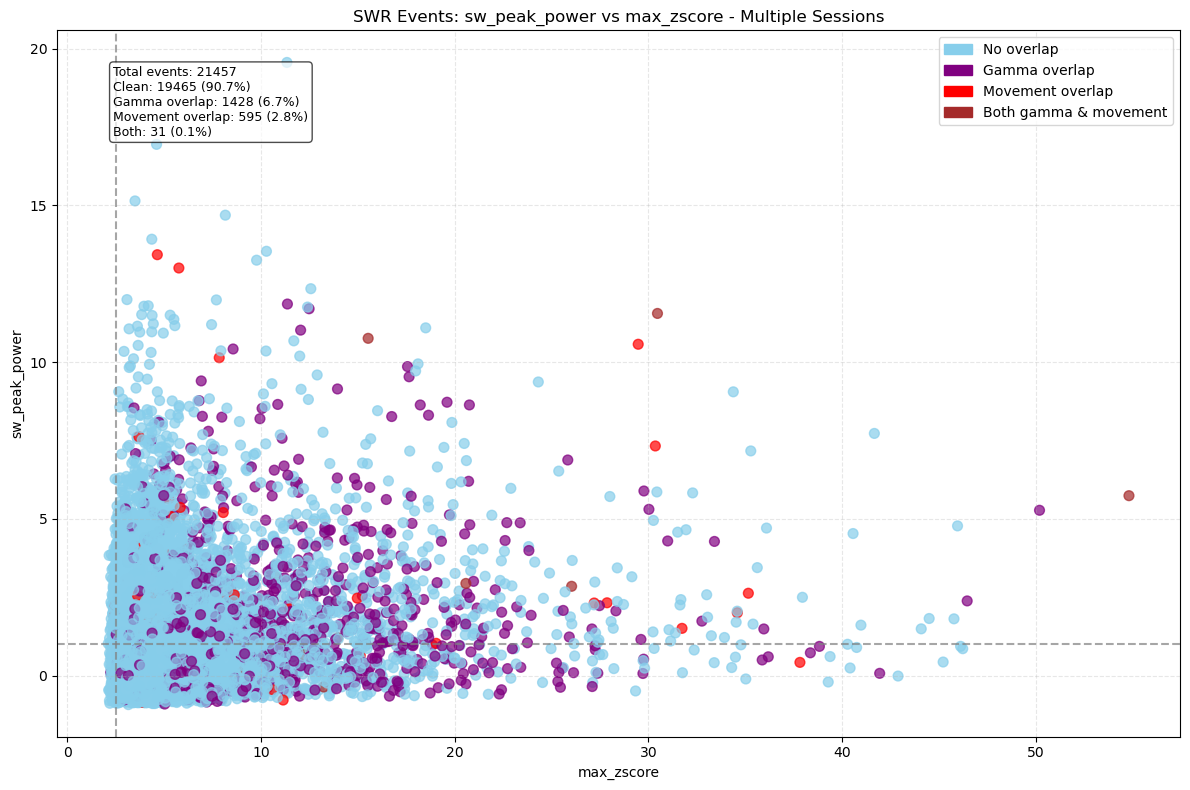

In [4]:
# Example usage:

# Plot across specific sessions
fig, ax = plotter.plot_swr_events(
    "allen_visbehave_swr_murphylab2024",
    ["1044385384", "1048196054"],
    x_col='max_zscore', 
    y_col='sw_peak_power',
    x_threshold=2.5,
    y_threshold=1,
    plot_name="my_first_plot"
)

# Access the data later
plot_data = plotter.get_plot_data("my_first_plot")
df = plot_data['data']
print(f"Number of events in the plot: {len(df)}")
plt.show()


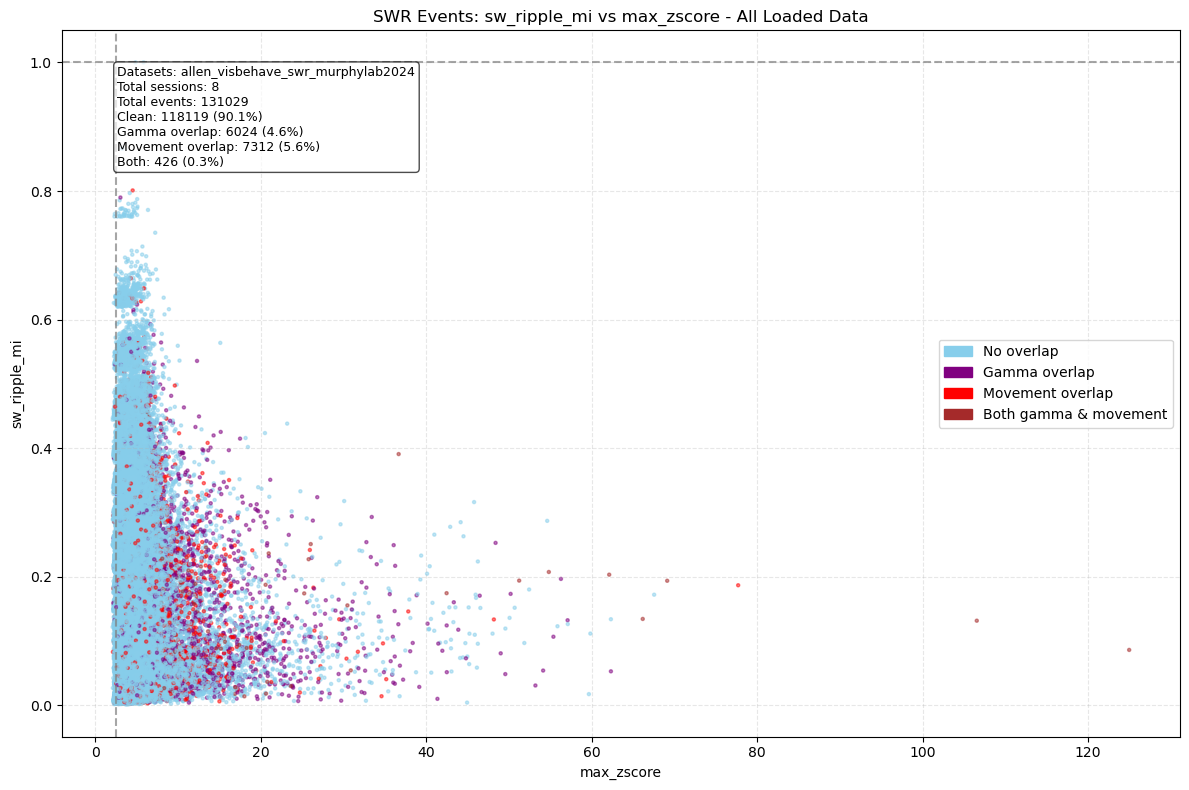

In [5]:
# Plot across ALL loaded data
fig, ax = plotter.plot_across_all_data(
    x_col='max_zscore', 
    y_col='sw_ripple_mi',
    x_threshold=2.5,
    y_threshold=1
)
# Access the scatter plot collections
for collection in ax.collections:
    # Reduce the size of the points
    collection.set_sizes([5])  # Change 10 to your preferred size (default was 50)
    # You can also adjust alpha if needed
    collection.set_alpha(0.5)  # Makes points more transparent

# Now show the plot
plt.show()



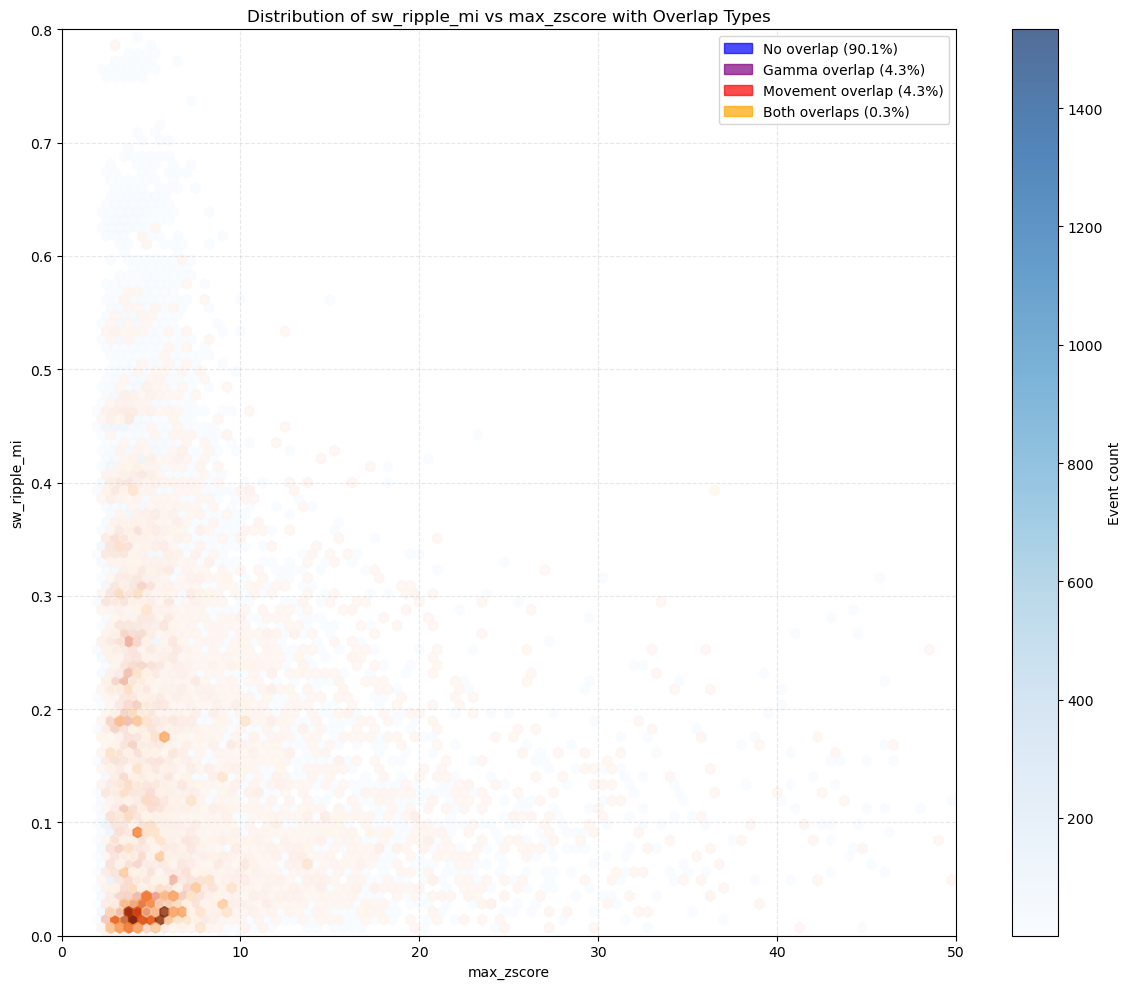

In [6]:
# Assuming you've already created a plot with plotter.plot_across_all_data()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Get the concatenated data from the stored plot
plot_data = plotter.get_plot_data("all_data_plot")
data = plot_data['data']

# ===== ADJUSTABLE PARAMETERS =====
# Variables to plot
x_variable = 'max_zscore'
y_variable = 'sw_ripple_mi'
x_label = 'max_zscore'
y_label = 'sw_ripple_mi'

# Plot parameters
x_min = 0      # Minimum value for x-axis
x_max = 50     # Maximum value for x-axis
y_min = 0      # Minimum value for y-axis 
y_max = 0.8    # Maximum value for y-axis
bins = 100     # Number of bins in each dimension
alpha = 0.7    # Transparency

# Figure parameters
fig_width = 12
fig_height = 10
grid_alpha = 0.3
fig_title = f'Distribution of {y_label} vs {x_label} with Overlap Types'
# ================================

# Create masks for different categories
clean_mask = ~data['overlaps_with_gamma'] & ~data['overlaps_with_movement']
gamma_mask = data['overlaps_with_gamma'] & ~data['overlaps_with_movement']
movement_mask = ~data['overlaps_with_movement'] & data['overlaps_with_gamma']
both_mask = data['overlaps_with_gamma'] & data['overlaps_with_movement']

# Create a figure
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Create a custom colormap for each category
cmap_clean = 'Blues'
cmap_gamma = 'Purples'
cmap_movement = 'Reds'
cmap_both = 'Oranges'

# Plot a single heatmap showing the absolute counts in each bin
# We'll use hexbin which shows counts directly (not normalized)
hb_clean = ax.hexbin(
    data.loc[clean_mask, x_variable], 
    data.loc[clean_mask, y_variable], 
    gridsize=bins, cmap=cmap_clean, 
    alpha=alpha, mincnt=1, 
    extent=[x_min, x_max, y_min, y_max],
    label='No overlap'
)

hb_gamma = ax.hexbin(
    data.loc[gamma_mask, x_variable], 
    data.loc[gamma_mask, y_variable], 
    gridsize=bins, cmap=cmap_gamma, 
    alpha=alpha, mincnt=1, 
    extent=[x_min, x_max, y_min, y_max],
    label='Gamma overlap'
)

hb_movement = ax.hexbin(
    data.loc[movement_mask, x_variable], 
    data.loc[movement_mask, y_variable], 
    gridsize=bins, cmap=cmap_movement, 
    alpha=alpha, mincnt=1, 
    extent=[x_min, x_max, y_min, y_max],
    label='Movement overlap'
)

hb_both = ax.hexbin(
    data.loc[both_mask, x_variable], 
    data.loc[both_mask, y_variable], 
    gridsize=bins, cmap=cmap_both, 
    alpha=alpha, mincnt=1, 
    extent=[x_min, x_max, y_min, y_max],
    label='Both overlaps'
)

# Add labels and title
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title(fig_title)
ax.grid(True, linestyle='--', alpha=grid_alpha)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Create a proper legend
import matplotlib.patches as mpatches
legend_patches = [
    mpatches.Patch(color='blue', alpha=0.7, label=f'No overlap ({clean_mask.sum()/len(data):.1%})'),
    mpatches.Patch(color='purple', alpha=0.7, label=f'Gamma overlap ({gamma_mask.sum()/len(data):.1%})'),
    mpatches.Patch(color='red', alpha=0.7, label=f'Movement overlap ({movement_mask.sum()/len(data):.1%})'),
    mpatches.Patch(color='orange', alpha=0.7, label=f'Both overlaps ({both_mask.sum()/len(data):.1%})')
]
ax.legend(handles=legend_patches)

# Add colorbar
cbar = plt.colorbar(hb_clean, label='Event count')

plt.tight_layout()
plt.show()

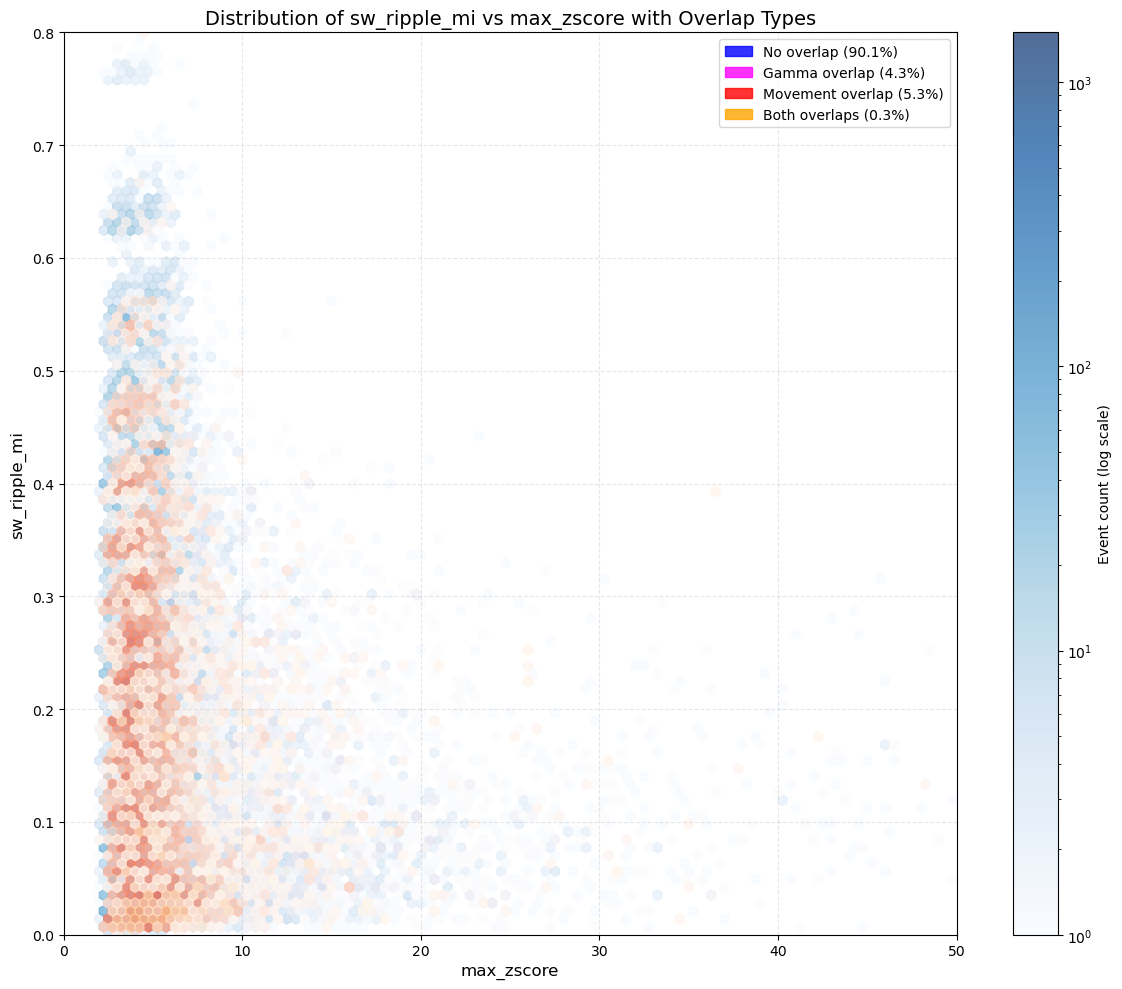

In [7]:
# Assuming you've already created a plot with plotter.plot_across_all_data()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.colors as colors

# Get the concatenated data from the stored plot
plot_data = plotter.get_plot_data("all_data_plot")
data = plot_data['data']

# ===== ADJUSTABLE PARAMETERS =====
# Variables to plot
x_variable = 'max_zscore'
y_variable = 'sw_ripple_mi'
x_label = 'max_zscore'
y_label = 'sw_ripple_mi'

# Plot parameters
x_min = 0      # Minimum value for x-axis
x_max = 50     # Maximum value for x-axis
y_min = 0      # Minimum value for y-axis 
y_max = 0.8    # Maximum value for y-axis
grid_size = 100  # Size of grid for binning (higher = more detailed)

# Color parameters
clean_color = 'blue'
gamma_color = 'magenta'
movement_color = 'red'
both_color = 'orange'
alpha_base = 0.7  # Base alpha value (higher = more opaque)
colormap_max = 1500  # Maximum value for color scale (adjust based on your data)

# Figure parameters
fig_width = 12
fig_height = 10
grid_alpha = 0.3
fig_title = f'Distribution of {y_label} vs {x_label} with Overlap Types'
# ================================

# Create masks for different categories
clean_mask = ~data['overlaps_with_gamma'] & ~data['overlaps_with_movement']
gamma_mask = data['overlaps_with_gamma'] & ~data['overlaps_with_movement']
movement_mask = ~data['overlaps_with_gamma'] & data['overlaps_with_movement']
both_mask = data['overlaps_with_gamma'] & data['overlaps_with_movement']

# Create a figure
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Create logarithmic norm for better color scaling
norm = colors.LogNorm(vmin=1, vmax=colormap_max)

# Plot hexbins for each category with more intense colors
hb_clean = ax.hexbin(
    data.loc[clean_mask, x_variable], 
    data.loc[clean_mask, y_variable], 
    gridsize=grid_size, 
    cmap=plt.cm.Blues, 
    norm=norm,
    alpha=alpha_base,
    mincnt=1, 
    extent=[x_min, x_max, y_min, y_max],
    label=f'No overlap ({clean_mask.sum()/len(data):.1%})'
)

hb_gamma = ax.hexbin(
    data.loc[gamma_mask, x_variable], 
    data.loc[gamma_mask, y_variable], 
    gridsize=grid_size, 
    cmap=plt.cm.Purples, 
    norm=norm,
    alpha=alpha_base,
    mincnt=1, 
    extent=[x_min, x_max, y_min, y_max],
    label=f'Gamma overlap ({gamma_mask.sum()/len(data):.1%})'
)

hb_movement = ax.hexbin(
    data.loc[movement_mask, x_variable], 
    data.loc[movement_mask, y_variable], 
    gridsize=grid_size, 
    cmap=plt.cm.Reds, 
    norm=norm,
    alpha=alpha_base,
    mincnt=1, 
    extent=[x_min, x_max, y_min, y_max],
    label=f'Movement overlap ({movement_mask.sum()/len(data):.1%})'
)

hb_both = ax.hexbin(
    data.loc[both_mask, x_variable], 
    data.loc[both_mask, y_variable], 
    gridsize=grid_size, 
    cmap=plt.cm.Oranges, 
    norm=norm,
    alpha=alpha_base,
    mincnt=1, 
    extent=[x_min, x_max, y_min, y_max],
    label=f'Both overlaps ({both_mask.sum()/len(data):.1%})'
)

# Add labels and title
ax.set_xlabel(x_label, fontsize=12)
ax.set_ylabel(y_label, fontsize=12)
ax.set_title(fig_title, fontsize=14)
ax.grid(True, linestyle='--', alpha=grid_alpha)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Create a proper legend with more visible colors
import matplotlib.patches as mpatches
legend_patches = [
    mpatches.Patch(color=clean_color, alpha=0.8, label=f'No overlap ({clean_mask.sum()/len(data):.1%})'),
    mpatches.Patch(color=gamma_color, alpha=0.8, label=f'Gamma overlap ({gamma_mask.sum()/len(data):.1%})'),
    mpatches.Patch(color=movement_color, alpha=0.8, label=f'Movement overlap ({movement_mask.sum()/len(data):.1%})'),
    mpatches.Patch(color=both_color, alpha=0.8, label=f'Both overlaps ({both_mask.sum()/len(data):.1%})')
]
ax.legend(handles=legend_patches, loc='upper right', fontsize=10)

# Add colorbar with logarithmic scale
cbar = plt.colorbar(hb_clean, label='Event count (log scale)')

plt.tight_layout()
plt.show()

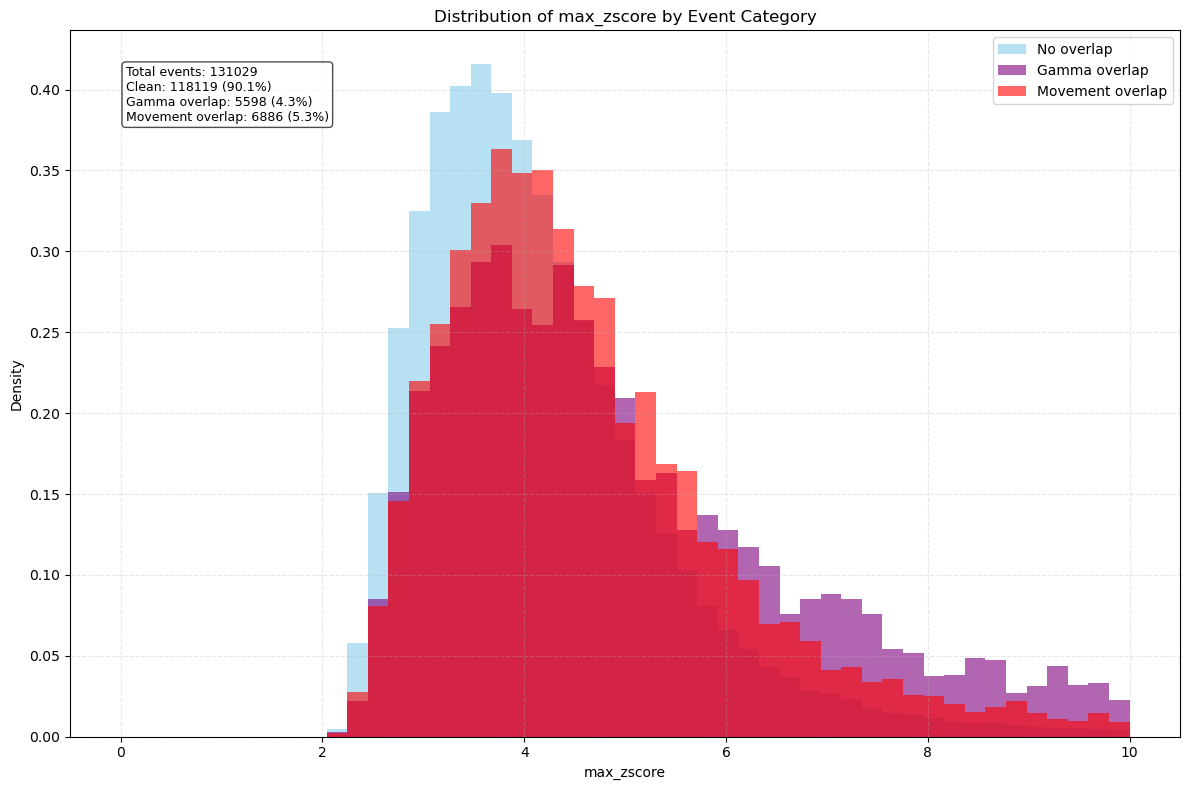

In [8]:
# Assuming you've already created a plot with plotter.plot_across_all_data()
import matplotlib.pyplot as plt
import numpy as np

# Get the concatenated data from the stored plot
plot_data = plotter.get_plot_data("all_data_plot")
data = plot_data['data']

# Create a new figure
fig, ax = plt.subplots(figsize=(12, 8))

# Define the bins for the histogram
bins = np.linspace(0, 10, 50)  # Adjust range based on your data

# Create masks for different categories
clean_mask = ~data['overlaps_with_gamma'] & ~data['overlaps_with_movement']
gamma_mask = data['overlaps_with_gamma'] & ~data['overlaps_with_movement']
movement_mask = ~data['overlaps_with_gamma'] & data['overlaps_with_movement']

# Plot histograms with the same colors as the scatter plot
ax.hist(data.loc[clean_mask, 'max_zscore'], bins=bins, alpha=0.6, 
        color='skyblue', label='No overlap', density=True)
ax.hist(data.loc[gamma_mask, 'max_zscore'], bins=bins, alpha=0.6, 
        color='purple', label='Gamma overlap', density=True)
ax.hist(data.loc[movement_mask, 'max_zscore'], bins=bins, alpha=0.6, 
        color='red', label='Movement overlap', density=True)

# Add labels and legend
ax.set_xlabel('max_zscore')
ax.set_ylabel('Density')
ax.set_title('Distribution of max_zscore by Event Category')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.3)

# Add count information
total_count = len(data)
clean_count = clean_mask.sum()
gamma_count = gamma_mask.sum()
movement_count = movement_mask.sum()

info_text = (
    f"Total events: {total_count}\n"
    f"Clean: {clean_count} ({clean_count/total_count:.1%})\n"
    f"Gamma overlap: {gamma_count} ({gamma_count/total_count:.1%})\n"
    f"Movement overlap: {movement_count} ({movement_count/total_count:.1%})"
)

props = dict(boxstyle='round', facecolor='white', alpha=0.7)
ax.text(0.05, 0.95, info_text, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

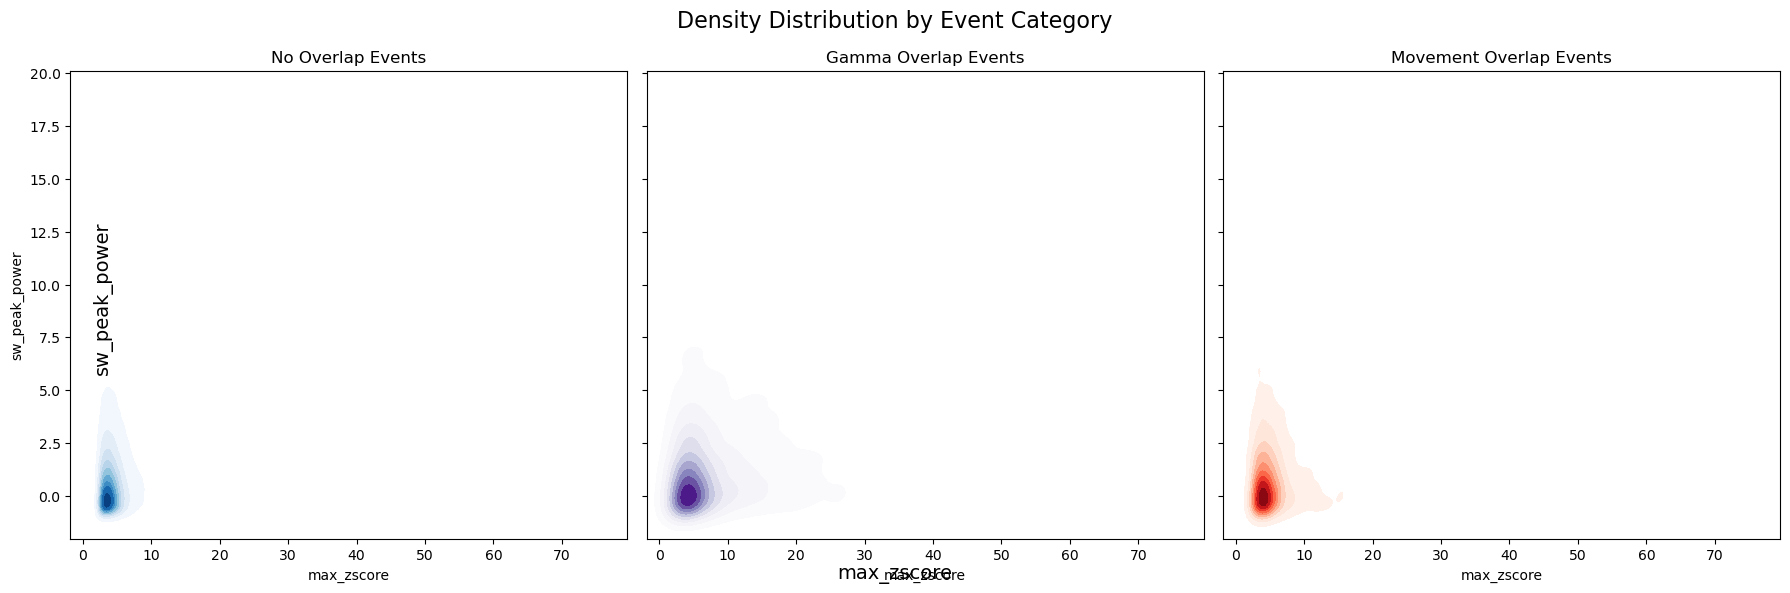

In [9]:
import seaborn as sns

# Create a new figure with 3 subplots (one for each category)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True, sharex=True)

# Create KDE plots for each category
sns.kdeplot(x=data.loc[clean_mask, 'max_zscore'], y=data.loc[clean_mask, 'sw_peak_power'],
            cmap="Blues", fill=True, ax=axes[0], levels=10)
axes[0].set_title("No Overlap Events")

sns.kdeplot(x=data.loc[gamma_mask, 'max_zscore'], y=data.loc[gamma_mask, 'sw_peak_power'],
            cmap="Purples", fill=True, ax=axes[1], levels=10)
axes[1].set_title("Gamma Overlap Events")

sns.kdeplot(x=data.loc[movement_mask, 'max_zscore'], y=data.loc[movement_mask, 'sw_peak_power'],
            cmap="Reds", fill=True, ax=axes[2], levels=10)
axes[2].set_title("Movement Overlap Events")

# Set common labels
fig.text(0.5, 0.04, 'max_zscore', ha='center', va='center', fontsize=14)
fig.text(0.06, 0.5, 'sw_peak_power', ha='center', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Density Distribution by Event Category', fontsize=16)

plt.tight_layout()
plt.show()

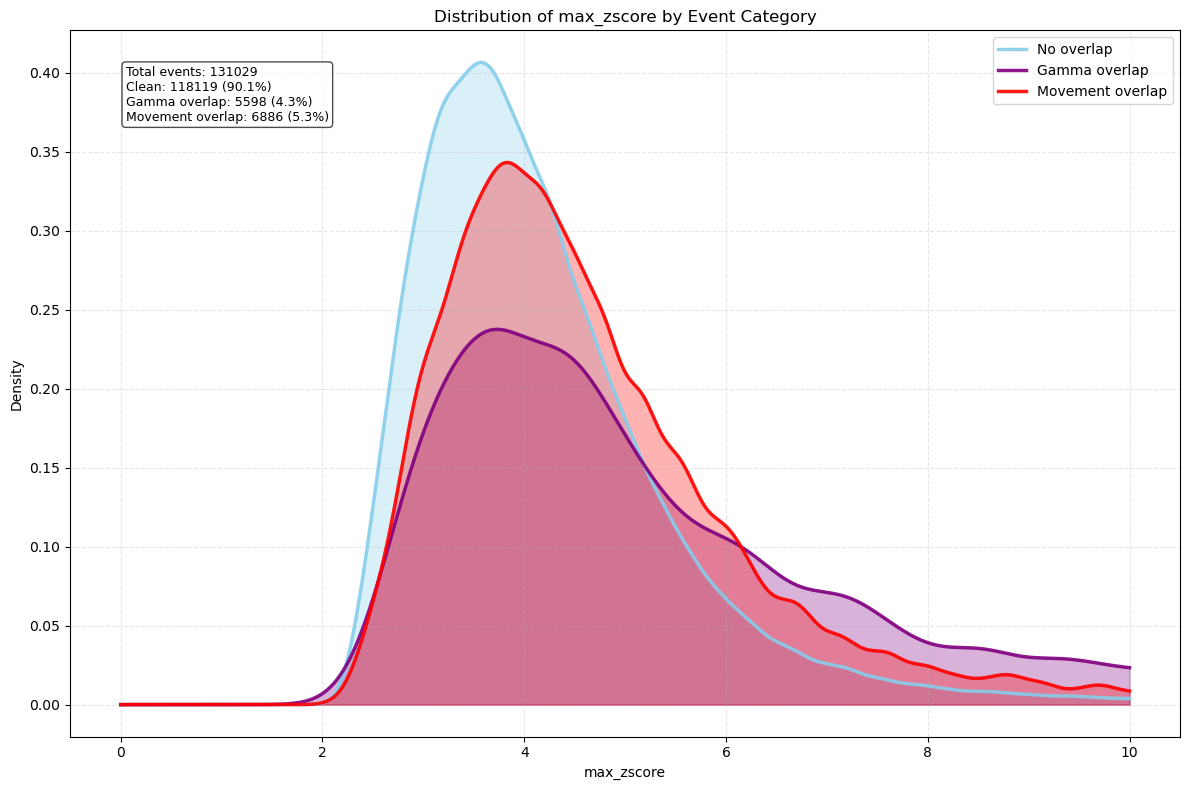

In [10]:
# Assuming you've already created a plot with plotter.plot_across_all_data()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

# Get the concatenated data from the stored plot
plot_data = plotter.get_plot_data("all_data_plot")
data = plot_data['data']

# ===== ADJUSTABLE PARAMETERS =====
# Variable to plot on x-axis
x_variable = 'max_zscore'
x_label = 'max_zscore'

# Plot parameters
min_value = 0     # Minimum value for x-axis
max_value = 10    # Maximum value for x-axis
num_points = 1000  # Number of points for density curve smoothness
bandwidth = 0.05    # KDE bandwidth (smaller = more detail, larger = smoother)

# Line parameters
line_width = 2.5
line_alpha = 0.9
fill_alpha = 0.3

# Colors for different categories
clean_color = 'skyblue'
gamma_color = 'purple'
movement_color = 'red'

# Figure parameters
fig_width = 12
fig_height = 8
grid_alpha = 0.3
fig_title = f'Distribution of {x_label} by Event Category'
# ================================

# Create a new figure
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Create masks for different categories
clean_mask = ~data['overlaps_with_gamma'] & ~data['overlaps_with_movement']
gamma_mask = data['overlaps_with_gamma'] & ~data['overlaps_with_movement']
movement_mask = ~data['overlaps_with_gamma'] & data['overlaps_with_movement']

# Create KDE plots for each category
x_grid = np.linspace(min_value, max_value, num_points)

# Clean events (blue)
clean_data = data.loc[clean_mask, x_variable].dropna()
if len(clean_data) > 0:
    kde_clean = stats.gaussian_kde(clean_data, bw_method=bandwidth)
    y_clean = kde_clean(x_grid)
    ax.plot(x_grid, y_clean, color=clean_color, linewidth=line_width, alpha=line_alpha, label='No overlap')
    ax.fill_between(x_grid, y_clean, alpha=fill_alpha, color=clean_color)

# Gamma events (purple)
gamma_data = data.loc[gamma_mask, x_variable].dropna()
if len(gamma_data) > 0:
    kde_gamma = stats.gaussian_kde(gamma_data, bw_method=bandwidth)
    y_gamma = kde_gamma(x_grid)
    ax.plot(x_grid, y_gamma, color=gamma_color, linewidth=line_width, alpha=line_alpha, label='Gamma overlap')
    ax.fill_between(x_grid, y_gamma, alpha=fill_alpha, color=gamma_color)

# Movement events (red)
movement_data = data.loc[movement_mask, x_variable].dropna()
if len(movement_data) > 0:
    kde_movement = stats.gaussian_kde(movement_data, bw_method=bandwidth)
    y_movement = kde_movement(x_grid)
    ax.plot(x_grid, y_movement, color=movement_color, linewidth=line_width, alpha=line_alpha, label='Movement overlap')
    ax.fill_between(x_grid, y_movement, alpha=fill_alpha, color=movement_color)

# Add labels and legend
ax.set_xlabel(x_label)
ax.set_ylabel('Density')
ax.set_title(fig_title)
ax.legend()
ax.grid(True, linestyle='--', alpha=grid_alpha)

# Add count information
total_count = len(data)
clean_count = clean_mask.sum()
gamma_count = gamma_mask.sum()
movement_count = movement_mask.sum()

info_text = (
    f"Total events: {total_count}\n"
    f"Clean: {clean_count} ({clean_count/total_count:.1%})\n"
    f"Gamma overlap: {gamma_count} ({gamma_count/total_count:.1%})\n"
    f"Movement overlap: {movement_count} ({movement_count/total_count:.1%})"
)

props = dict(boxstyle='round', facecolor='white', alpha=0.7)
ax.text(0.05, 0.95, info_text, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()


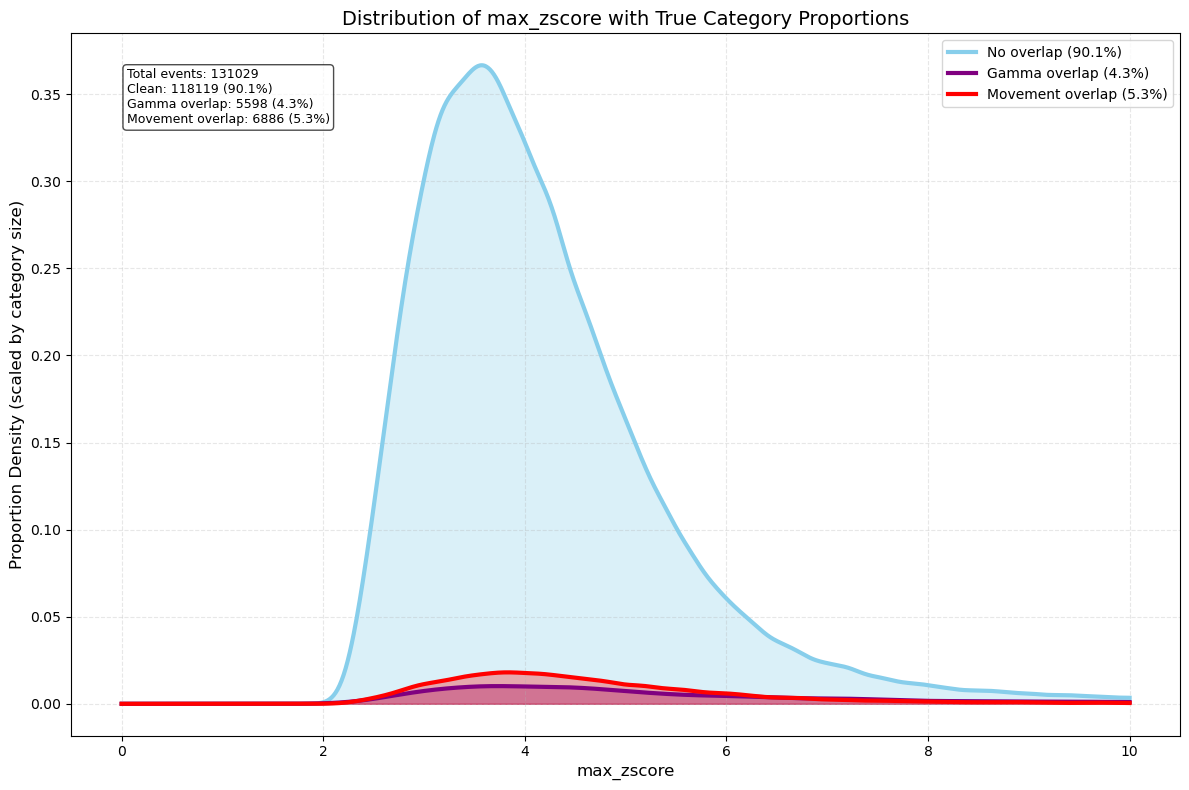

In [11]:
# Assuming you've already created a plot with plotter.plot_across_all_data()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

# Get the concatenated data from the stored plot
plot_data = plotter.get_plot_data("all_data_plot")
data = plot_data['data']

# ===== ADJUSTABLE PARAMETERS =====
# Variable to plot on x-axis
x_variable = 'max_zscore'
x_label = 'max_zscore'

# Plot parameters
min_value = 0     # Minimum value for x-axis
max_value = 10    # Maximum value for x-axis
num_points = 1000  # Number of points for density curve smoothness
bandwidth = 0.05   # KDE bandwidth (smaller = more detail, larger = smoother)

# Line parameters
line_width = 3
fill_alpha = 0.3

# Colors
clean_color = 'skyblue'
gamma_color = 'purple'
movement_color = 'red'

# Figure parameters
fig_width = 12
fig_height = 8
grid_alpha = 0.3
fig_title = f'Distribution of {x_label} with True Category Proportions'
# ================================

# Create masks for different categories
clean_mask = ~data['overlaps_with_gamma'] & ~data['overlaps_with_movement']
gamma_mask = data['overlaps_with_gamma'] & ~data['overlaps_with_movement']
movement_mask = ~data['overlaps_with_gamma'] & data['overlaps_with_movement']

# Get counts
total_count = len(data)
clean_count = clean_mask.sum()
gamma_count = gamma_mask.sum()
movement_count = movement_mask.sum()

# Create a new figure
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Create smooth x grid for KDE
x_grid = np.linspace(min_value, max_value, num_points)

# Scale each KDE by the proportion of the category
clean_data = data.loc[clean_mask, x_variable].dropna()
gamma_data = data.loc[gamma_mask, x_variable].dropna()
movement_data = data.loc[movement_mask, x_variable].dropna()

# Generate the KDEs scaled by category size
clean_kde = stats.gaussian_kde(clean_data, bw_method=bandwidth)(x_grid) * (clean_count/total_count)
gamma_kde = stats.gaussian_kde(gamma_data, bw_method=bandwidth)(x_grid) * (gamma_count/total_count)
movement_kde = stats.gaussian_kde(movement_data, bw_method=bandwidth)(x_grid) * (movement_count/total_count)

# Plot the scaled KDEs with fills
ax.plot(x_grid, clean_kde, color=clean_color, linewidth=line_width, 
       label=f'No overlap ({clean_count/total_count:.1%})')
ax.fill_between(x_grid, clean_kde, alpha=fill_alpha, color=clean_color)

ax.plot(x_grid, gamma_kde, color=gamma_color, linewidth=line_width, 
       label=f'Gamma overlap ({gamma_count/total_count:.1%})')
ax.fill_between(x_grid, gamma_kde, alpha=fill_alpha, color=gamma_color)

ax.plot(x_grid, movement_kde, color=movement_color, linewidth=line_width, 
       label=f'Movement overlap ({movement_count/total_count:.1%})')
ax.fill_between(x_grid, movement_kde, alpha=fill_alpha, color=movement_color)

# Add labels and title
ax.set_xlabel(x_label, fontsize=12)
ax.set_ylabel('Proportion Density (scaled by category size)', fontsize=12)
ax.set_title(fig_title, fontsize=14)

# Add count information in a text box
info_text = (
    f"Total events: {total_count}\n"
    f"Clean: {clean_count} ({clean_count/total_count:.1%})\n"
    f"Gamma overlap: {gamma_count} ({gamma_count/total_count:.1%})\n"
    f"Movement overlap: {movement_count} ({movement_count/total_count:.1%})"
)

props = dict(boxstyle='round', facecolor='white', alpha=0.7)
ax.text(0.05, 0.95, info_text, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# Add grid
ax.grid(True, linestyle='--', alpha=grid_alpha)

# Add legend
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

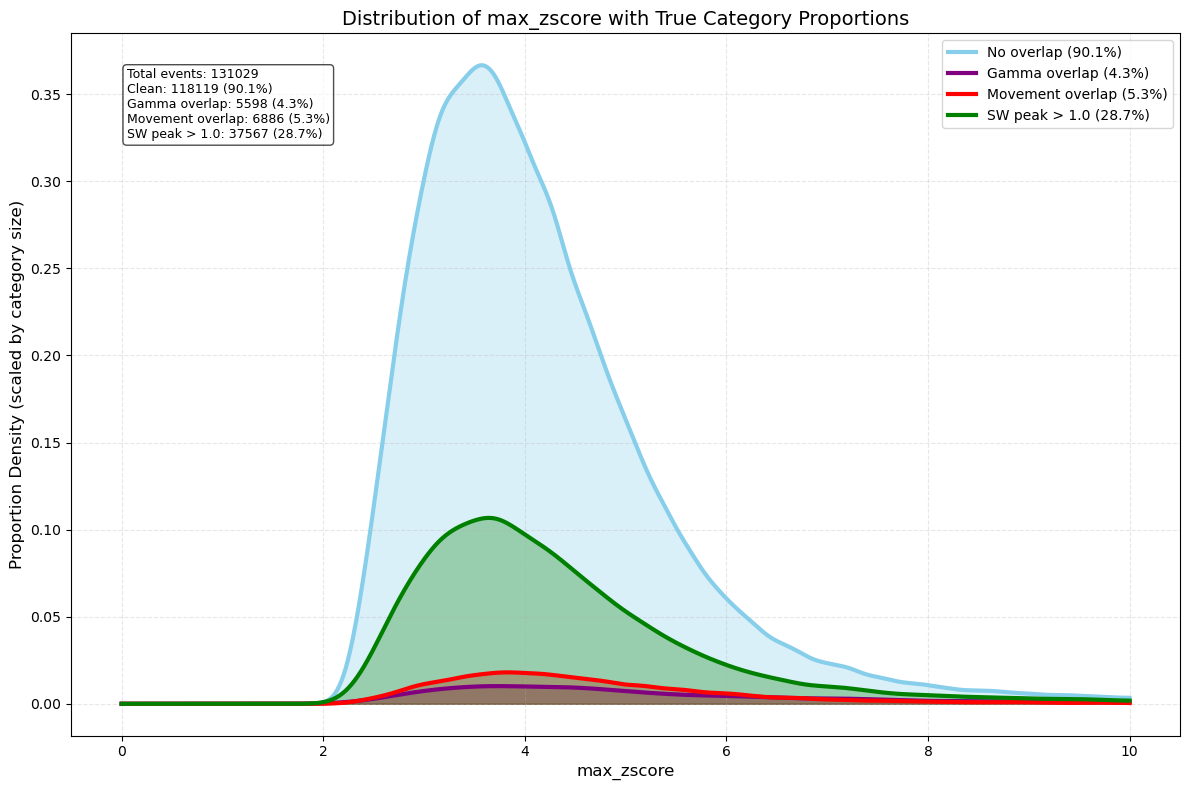

In [12]:
# Assuming you've already created a plot with plotter.plot_across_all_data()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

# Get the concatenated data from the stored plot
plot_data = plotter.get_plot_data("all_data_plot")
data = plot_data['data']

# ===== ADJUSTABLE PARAMETERS =====
# Variable to plot on x-axis
x_variable = 'max_zscore'
x_label = 'max_zscore'

# SW peak threshold
sw_peak_threshold = 1.0
sw_peak_variable = 'sw_peak_power'

# Plot parameters
min_value = 0     # Minimum value for x-axis
max_value = 10    # Maximum value for x-axis
num_points = 1000  # Number of points for density curve smoothness
bandwidth = 0.05   # KDE bandwidth (smaller = more detail, larger = smoother)

# Line parameters
line_width = 3
fill_alpha = 0.3

# Colors
clean_color = 'skyblue'
gamma_color = 'purple'
movement_color = 'red'
high_sw_peak_color = 'green'

# Figure parameters
fig_width = 12
fig_height = 8
grid_alpha = 0.3
fig_title = f'Distribution of {x_label} with True Category Proportions'
# ================================

# Create masks for different categories
clean_mask = ~data['overlaps_with_gamma'] & ~data['overlaps_with_movement']
gamma_mask = data['overlaps_with_gamma'] & ~data['overlaps_with_movement']
movement_mask = ~data['overlaps_with_gamma'] & data['overlaps_with_movement']
high_sw_peak_mask = data[sw_peak_variable] > sw_peak_threshold

# Get counts
total_count = len(data)
clean_count = clean_mask.sum()
gamma_count = gamma_mask.sum()
movement_count = movement_mask.sum()
high_sw_peak_count = high_sw_peak_mask.sum()

# Create a new figure
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Create smooth x grid for KDE
x_grid = np.linspace(min_value, max_value, num_points)

# Scale each KDE by the proportion of the category
clean_data = data.loc[clean_mask, x_variable].dropna()
gamma_data = data.loc[gamma_mask, x_variable].dropna()
movement_data = data.loc[movement_mask, x_variable].dropna()
high_sw_peak_data = data.loc[high_sw_peak_mask, x_variable].dropna()

# Generate the KDEs scaled by category size
clean_kde = stats.gaussian_kde(clean_data, bw_method=bandwidth)(x_grid) * (clean_count/total_count)
gamma_kde = stats.gaussian_kde(gamma_data, bw_method=bandwidth)(x_grid) * (gamma_count/total_count)
movement_kde = stats.gaussian_kde(movement_data, bw_method=bandwidth)(x_grid) * (movement_count/total_count)
high_sw_peak_kde = stats.gaussian_kde(high_sw_peak_data, bw_method=bandwidth)(x_grid) * (high_sw_peak_count/total_count)

# Plot the scaled KDEs with fills
ax.plot(x_grid, clean_kde, color=clean_color, linewidth=line_width, 
       label=f'No overlap ({clean_count/total_count:.1%})')
ax.fill_between(x_grid, clean_kde, alpha=fill_alpha, color=clean_color)

ax.plot(x_grid, gamma_kde, color=gamma_color, linewidth=line_width, 
       label=f'Gamma overlap ({gamma_count/total_count:.1%})')
ax.fill_between(x_grid, gamma_kde, alpha=fill_alpha, color=gamma_color)

ax.plot(x_grid, movement_kde, color=movement_color, linewidth=line_width, 
       label=f'Movement overlap ({movement_count/total_count:.1%})')
ax.fill_between(x_grid, movement_kde, alpha=fill_alpha, color=movement_color)

ax.plot(x_grid, high_sw_peak_kde, color=high_sw_peak_color, linewidth=line_width, 
       label=f'SW peak > {sw_peak_threshold} ({high_sw_peak_count/total_count:.1%})')
ax.fill_between(x_grid, high_sw_peak_kde, alpha=fill_alpha, color=high_sw_peak_color)

# Add labels and title
ax.set_xlabel(x_label, fontsize=12)
ax.set_ylabel('Proportion Density (scaled by category size)', fontsize=12)
ax.set_title(fig_title, fontsize=14)

# Add count information in a text box
info_text = (
    f"Total events: {total_count}\n"
    f"Clean: {clean_count} ({clean_count/total_count:.1%})\n"
    f"Gamma overlap: {gamma_count} ({gamma_count/total_count:.1%})\n"
    f"Movement overlap: {movement_count} ({movement_count/total_count:.1%})\n"
    f"SW peak > {sw_peak_threshold}: {high_sw_peak_count} ({high_sw_peak_count/total_count:.1%})"
)

props = dict(boxstyle='round', facecolor='white', alpha=0.7)
ax.text(0.05, 0.95, info_text, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# Add grid
ax.grid(True, linestyle='--', alpha=grid_alpha)

# Add legend
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

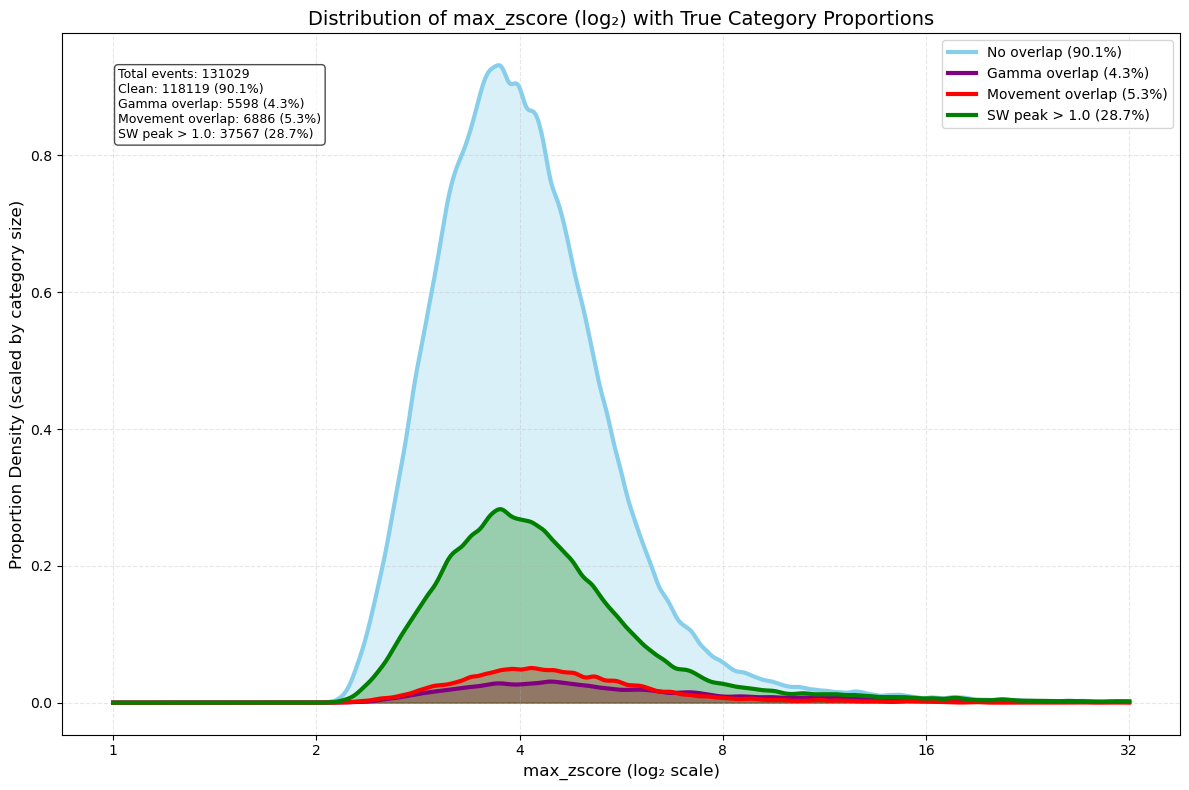

In [13]:
# Assuming you've already created a plot with plotter.plot_across_all_data()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

# Get the concatenated data from the stored plot
plot_data = plotter.get_plot_data("all_data_plot")
data = plot_data['data']

# ===== ADJUSTABLE PARAMETERS =====
# Variable to plot on x-axis
x_variable = 'max_zscore'
x_label = 'max_zscore (log₂ scale)'

# SW peak threshold
sw_peak_threshold = 1.0
sw_peak_variable = 'sw_peak_power'

# Plot parameters
min_value = 0     # Minimum value for log-scaled x-axis
max_value = 5     # Maximum value for log-scaled x-axis (log₂(32) ≈ 5)
num_points = 1000  # Number of points for density curve smoothness
bandwidth = 0.05   # KDE bandwidth (smaller = more detail, larger = smoother)

# Line parameters
line_width = 3
fill_alpha = 0.3

# Colors
clean_color = 'skyblue'
gamma_color = 'purple'
movement_color = 'red'
high_sw_peak_color = 'green'

# Figure parameters
fig_width = 12
fig_height = 8
grid_alpha = 0.3
fig_title = f'Distribution of {x_variable} (log₂) with True Category Proportions'
# ================================

# Create masks for different categories
clean_mask = ~data['overlaps_with_gamma'] & ~data['overlaps_with_movement']
gamma_mask = data['overlaps_with_gamma'] & ~data['overlaps_with_movement']
movement_mask = ~data['overlaps_with_gamma'] & data['overlaps_with_movement']
high_sw_peak_mask = data[sw_peak_variable] > sw_peak_threshold

# Get counts
total_count = len(data)
clean_count = clean_mask.sum()
gamma_count = gamma_mask.sum()
movement_count = movement_mask.sum()
high_sw_peak_count = high_sw_peak_mask.sum()

# Create a new figure
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Create smooth x grid for KDE in log2 space
x_grid = np.linspace(min_value, max_value, num_points)

# Apply log2 transformation to the data
# Adding a small epsilon to avoid log(0)
epsilon = 1e-10
log2_transform = lambda x: np.log2(x + epsilon)

# Transform data to log2 scale
clean_data = log2_transform(data.loc[clean_mask, x_variable].dropna())
gamma_data = log2_transform(data.loc[gamma_mask, x_variable].dropna())
movement_data = log2_transform(data.loc[movement_mask, x_variable].dropna())
high_sw_peak_data = log2_transform(data.loc[high_sw_peak_mask, x_variable].dropna())

# Generate the KDEs scaled by category size
clean_kde = stats.gaussian_kde(clean_data, bw_method=bandwidth)(x_grid) * (clean_count/total_count)
gamma_kde = stats.gaussian_kde(gamma_data, bw_method=bandwidth)(x_grid) * (gamma_count/total_count)
movement_kde = stats.gaussian_kde(movement_data, bw_method=bandwidth)(x_grid) * (movement_count/total_count)
high_sw_peak_kde = stats.gaussian_kde(high_sw_peak_data, bw_method=bandwidth)(x_grid) * (high_sw_peak_count/total_count)

# Plot the scaled KDEs with fills
ax.plot(x_grid, clean_kde, color=clean_color, linewidth=line_width, 
       label=f'No overlap ({clean_count/total_count:.1%})')
ax.fill_between(x_grid, clean_kde, alpha=fill_alpha, color=clean_color)

ax.plot(x_grid, gamma_kde, color=gamma_color, linewidth=line_width, 
       label=f'Gamma overlap ({gamma_count/total_count:.1%})')
ax.fill_between(x_grid, gamma_kde, alpha=fill_alpha, color=gamma_color)

ax.plot(x_grid, movement_kde, color=movement_color, linewidth=line_width, 
       label=f'Movement overlap ({movement_count/total_count:.1%})')
ax.fill_between(x_grid, movement_kde, alpha=fill_alpha, color=movement_color)

ax.plot(x_grid, high_sw_peak_kde, color=high_sw_peak_color, linewidth=line_width, 
       label=f'SW peak > {sw_peak_threshold} ({high_sw_peak_count/total_count:.1%})')
ax.fill_between(x_grid, high_sw_peak_kde, alpha=fill_alpha, color=high_sw_peak_color)

# Add labels and title
ax.set_xlabel(x_label, fontsize=12)
ax.set_ylabel('Proportion Density (scaled by category size)', fontsize=12)
ax.set_title(fig_title, fontsize=14)

# Add log-scale tick labels (show actual values, not log values)
log2_ticks = np.arange(0, max_value+1)
ax.set_xticks(log2_ticks)
ax.set_xticklabels([f"{2**x:.0f}" for x in log2_ticks])

# Add count information in a text box
info_text = (
    f"Total events: {total_count}\n"
    f"Clean: {clean_count} ({clean_count/total_count:.1%})\n"
    f"Gamma overlap: {gamma_count} ({gamma_count/total_count:.1%})\n"
    f"Movement overlap: {movement_count} ({movement_count/total_count:.1%})\n"
    f"SW peak > {sw_peak_threshold}: {high_sw_peak_count} ({high_sw_peak_count/total_count:.1%})"
)

props = dict(boxstyle='round', facecolor='white', alpha=0.7)
ax.text(0.05, 0.95, info_text, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# Add grid
ax.grid(True, linestyle='--', alpha=grid_alpha)

# Add legend
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [14]:
session_data[0].columns

Index(['Unnamed: 0', 'start_time', 'end_time', 'duration', 'max_thresh',
       'mean_zscore', 'median_zscore', 'max_zscore', 'min_zscore', 'area',
       'total_energy', 'Peak_time', 'sw_exceeds_threshold', 'sw_peak_power',
       'sw_peak_time', 'sw_ripple_plv', 'sw_ripple_mi', 'sw_ripple_clcorr',
       'overlaps_with_gamma', 'gamma_overlap_percent',
       'overlaps_with_movement', 'movement_overlap_percent'],
      dtype='object')

In [15]:
base_path = "/space/scratch/SWR_final_pipeline/osf_v2_dir"
dataset_name = "allen_visbehave_swr_murphylab2024_lfp_data"
shesh = ["1044594870"]  # Or None to load all sessions

sw_summaries = plotter.load_sw_component_summaries(dataset_name, shesh)

# Access data for the first session and probe
first_session = list(sw_summaries.keys())[0]
first_probe = list(sw_summaries[first_session].keys())[0]
summary = sw_summaries[first_session][first_probe]

# Print some information about the summary
print(f"Available keys in summary: {list(summary.keys())}")

Loading SW component summaries: 100%|██████████| 1/1 [00:00<00:00, 327.30it/s]

Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024_lfp_data/lfp_session_1044594870/probe_1044791097_sw_component_summary.json.gz
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024_lfp_data/lfp_session_1044594870/probe_1044791096_sw_component_summary.json.gz
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024_lfp_data/lfp_session_1044594870/probe_1044791098_sw_component_summary.json.gz
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024_lfp_data/lfp_session_1044594870/probe_1044791094_sw_component_summary.json.gz
Available keys in summary: ['channel_ids', 'modulation_indices', 'circular_linear_corrs', 'depths', 'selection_metric', 'best_channel_id']


In [31]:
def analyze_ripple_metrics_by_depth_proper(
        plotter,
        dataset_name,
        session_ids=None,
        min_samples: int = 2,
        figsize: tuple = (12, 10)):
    """
    Plot ripple modulation indices and circular‑linear correlations versus
    *relative* depth.  Best channel = 0 µm; every other channel is a negative
    multiple of the probe pitch (Δ).

    The grid is global: we first determine Δ and the largest depth offset
    across *all* probes, then use that same set of depth bins everywhere.
    """
    # ---------------- standard imports --------------------------
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    # ============================================================
    # 0.  Load summaries
    # ============================================================
    sw_summaries = plotter.load_sw_component_summaries(dataset_name,
                                                       session_ids)
    if not sw_summaries:
        print("No SW component summaries found")
        return None

    # ============================================================
    # 1.  Pass #1 – discover Δ and the largest offset
    # ============================================================
    positive_diffs = []
    max_offset     = 0.0

    for probes in sw_summaries.values():
        for summary in probes.values():
            if not all(k in summary for k in
                       ('modulation_indices', 'depths')):
                continue

            depths = np.asarray(summary['depths'], dtype=float)
            if depths.size < 2:
                continue

            # physical pitch candidates on this probe
            diffs = np.diff(np.sort(np.unique(depths)))
            positive_diffs.extend(diffs[diffs > 0])

            # distance from best channel on this probe
            best_depth = depths[np.argmax(summary['modulation_indices'])]
            max_offset = max(max_offset,
                             np.max(np.abs(depths - best_depth)))

    if not positive_diffs:
        print("Could not determine channel spacing (Δ).")
        return None

    Δ = float(np.min(positive_diffs))        # physical pitch
    N = int(np.ceil(max_offset / Δ))         # furthest bin index

    # The global grid: 0, –Δ, –2Δ, … , –NΔ
    depth_grid = -Δ * np.arange(0, N + 1, dtype=int)

    # Dicts keyed by those exact depth values
    modulation_by_depth  = {d: [] for d in depth_grid}
    correlation_by_depth = {d: [] for d in depth_grid}

    # ============================================================
    # 2.  Pass #2 – populate the grid
    # ============================================================
    for probes in sw_summaries.values():
        for summary in probes.values():

            if not all(k in summary for k in
                       ('modulation_indices', 'circular_linear_corrs', 'depths')):
                continue

            mod_vals = np.asarray(summary['modulation_indices'],  dtype=float)
            corr_vals = np.asarray(summary['circular_linear_corrs'], dtype=float)
            depths    = np.asarray(summary['depths'],              dtype=float)
            if depths.size < 2:
                continue

            best_depth = depths[np.argmax(mod_vals)]

            for d, m, c in zip(depths, mod_vals, corr_vals):
                steps     = int(round(abs(d - best_depth) / Δ))
                rel_depth = -steps * Δ                         # 0, –Δ, –2Δ, …

                modulation_by_depth [rel_depth].append(m)
                correlation_by_depth[rel_depth].append(c)

    # ============================================================
    # 3.  Build tidy DataFrames (keep only bins with ≥ min_samples)
    # ============================================================
    mod_df = pd.DataFrame([
        {"depth": d, "value": v}
        for d, vals in modulation_by_depth.items()  if len(vals) >= min_samples
        for v in vals
    ])
    corr_df = pd.DataFrame([
        {"depth": d, "value": v}
        for d, vals in correlation_by_depth.items() if len(vals) >= min_samples
        for v in vals
    ])

    if mod_df.empty or corr_df.empty:
        print(f"No depth bins with at least {min_samples} samples.")
        return None

    # x‑axis order: 0, –Δ, –2Δ, …
    depth_order = sorted(mod_df["depth"].unique(), reverse=True)

    # ============================================================
    # 4.  Plot
    # ============================================================
    fig, axs = plt.subplots(2, 1, figsize=figsize)

    # -- Modulation index ----------------------------------------
    sns.boxplot(x="depth", y="value", data=mod_df,
                order=depth_order, ax=axs[0])
    sns.stripplot(x="depth", y="value", data=mod_df,
                  order=depth_order, size=4, color="black",
                  alpha=0.5, ax=axs[0])

    axs[0].set_ylabel("Modulation Index", fontsize=12)
    axs[0].set_title("Ripple Modulation Index by Channel Depth", fontsize=14)
    axs[0].grid(True, linestyle="--", alpha=0.3)

    # sample counts
    for i, d in enumerate(depth_order):
        n = (mod_df["depth"] == d).sum()
        axs[0].text(i, axs[0].get_ylim()[1]*0.98, f"n={n}",
                    ha="center", va="top", fontsize=9)

    # -- Circular‑linear correlation -----------------------------
    sns.boxplot(x="depth", y="value", data=corr_df,
                order=depth_order, ax=axs[1])
    sns.stripplot(x="depth", y="value", data=corr_df,
                  order=depth_order, size=4, color="black",
                  alpha=0.5, ax=axs[1])

    axs[1].set_xlabel("Depth from Best Channel (µm)", fontsize=12)
    axs[1].set_ylabel("Circular‑Linear Correlation", fontsize=12)
    axs[1].set_title("Ripple Circular‑Linear Correlation by Channel Depth",
                     fontsize=14)
    axs[1].grid(True, linestyle="--", alpha=0.3)

    for i, d in enumerate(depth_order):
        n = (corr_df["depth"] == d).sum()
        axs[1].text(i, axs[1].get_ylim()[1]*0.98, f"n={n}",
                    ha="center", va="top", fontsize=9)

    plt.tight_layout()
    return fig


Loading SW component summaries: 100%|██████████| 8/8 [00:00<00:00, 562.18it/s]


Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024_lfp_data/lfp_session_1044385384/probe_1044506935_sw_component_summary.json.gz
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024_lfp_data/lfp_session_1044385384/probe_1044506937_sw_component_summary.json.gz
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024_lfp_data/lfp_session_1044385384/probe_1044506936_sw_component_summary.json.gz
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024_lfp_data/lfp_session_1044385384/probe_1044506933_sw_component_summary.json.gz
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024_lfp_data/lfp_session_1048196054/probe_1048335291_sw_component_summary.json.gz
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024_lfp_data/lfp_session_1049273528/probe_1049417651_sw_component_summary.json.gz
Loaded: /s

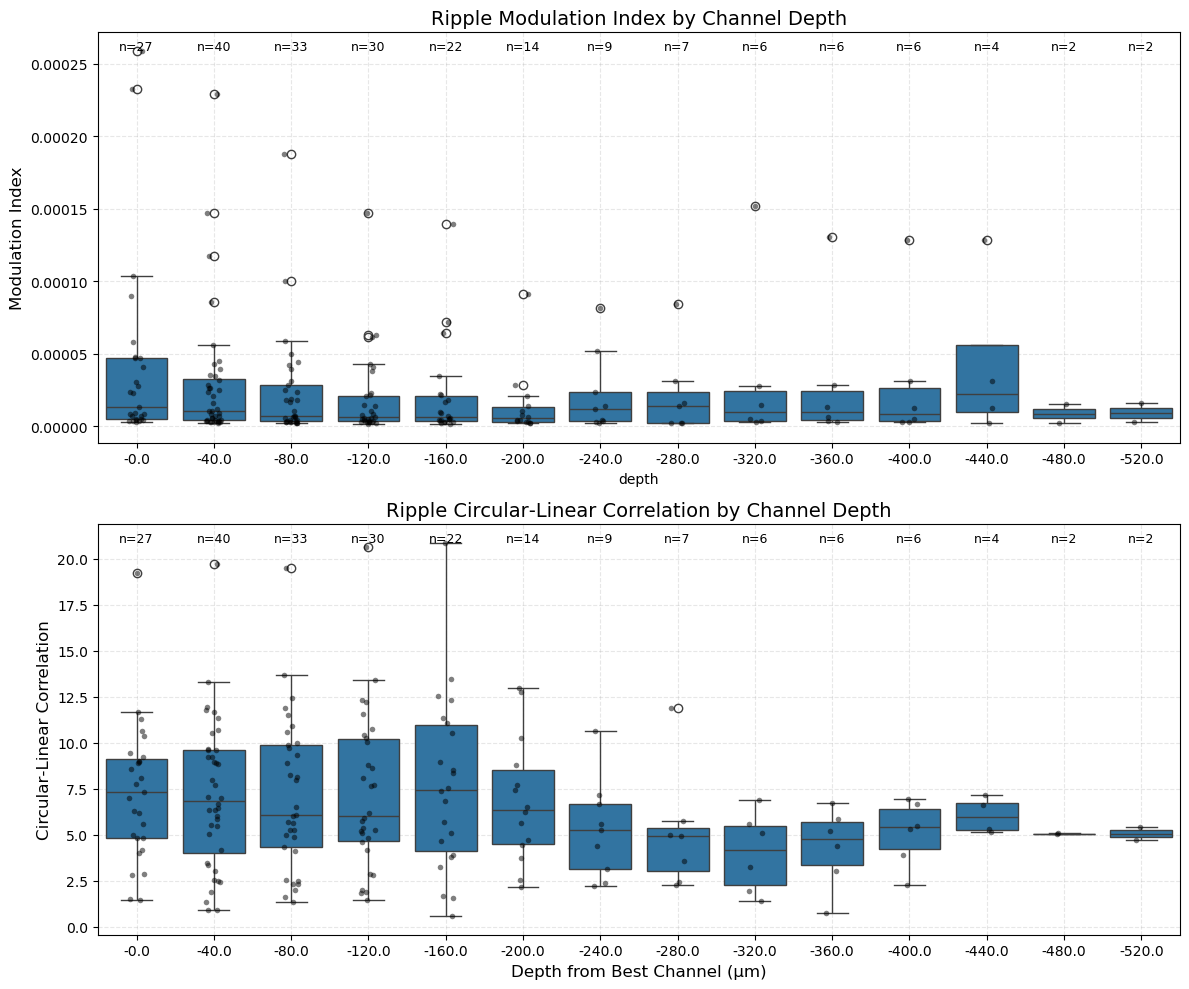

In [32]:
# Define parameters
dataset_name = "allen_visbehave_swr_murphylab2024_lfp_data"

# Analyze and plot
fig = analyze_ripple_metrics_by_depth_proper(plotter, dataset_name, session_ids)

# Show the plot
import matplotlib.pyplot as plt
plt.show()

In [ ]:
def plot_best_channel_depth_distribution(plotter,
                                         dataset_name,
                                         session_ids=None,
                                         figsize=(10, 6),
                                         reference_point="top"):
    """
    Histogram of the depth of the *best* channel on every probe,
    expressed in multiples of the probe pitch (Δ).

    reference_point
    ----------------
    "top"    → shallowest channel = 0, deeper channels negative
    "center" → probe midpoint     = 0, up / down are ± multiples of Δ
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    sw_summaries = plotter.load_sw_component_summaries(dataset_name,
                                                       session_ids)
    if not sw_summaries:
        print("No SW component summaries found")
        return None

    rel_depth_steps = []      # integer steps: 0, –1, –2, …
    depth_intervals = []      # one Δ per probe

    # ------------------------------------------------------------
    # 1. loop over probes
    # ------------------------------------------------------------
    for session_id, probes in sw_summaries.items():
        for probe_id, summary in probes.items():

            if not all(k in summary for k in ("modulation_indices", "depths")):
                continue

            depths = np.sort(np.asarray(summary["depths"], dtype=float))
            if depths.size < 2:
                continue

            # ---------- pitch (Δ) --------------------------------
            diffs = np.diff(np.unique(depths))
            positive_diffs = diffs[diffs > 0]
            if positive_diffs.size == 0:
                continue
            Δ = float(np.min(positive_diffs))          # physical pitch
            depth_intervals.append(Δ)

            # ---------- best channel -----------------------------
            best_idx   = int(np.argmax(summary["modulation_indices"]))
            best_depth = depths[best_idx]

            if reference_point == "top":
                ref_depth = depths[0]                   # shallowest
            elif reference_point == "center":
                ref_depth = 0.5 * (depths[0] + depths[-1])
            else:
                print(f"Unknown reference point: {reference_point}")
                continue

            # ---------- integer step offset ----------------------
            steps = int(round((best_depth - ref_depth) / Δ))
            rel_depth_steps.append(steps)               # may be 0, +k or –k

    if not rel_depth_steps:
        print("No valid data found")
        return None

    # ------------------------------------------------------------
    # 2. build the histogram
    # ------------------------------------------------------------
    fig, ax = plt.subplots(figsize=figsize)

    sns.histplot(rel_depth_steps,
                 bins=np.arange(min(rel_depth_steps) - 0.5,
                                max(rel_depth_steps) + 1.5),
                 ax=ax,
                 color="steelblue",
                 edgecolor="black",
                 alpha=0.7)

    # axis labels
    if reference_point == "top":
        xlab = "Steps below shallowest channel (0 = shallowest)"
    else:
        xlab = "Steps from probe centre (0 = centre; + = deeper)"

    ax.set_xlabel(xlab, fontsize=12)
    ax.set_ylabel("Count (number of probes)", fontsize=12)
    ax.set_title("Distribution of Best‑Channel Depths", fontsize=14)
    ax.grid(True, linestyle="--", alpha=0.3)

    # annotation box
    total_probes   = len(rel_depth_steps)
    median_pitch   = np.median(depth_intervals)
    ax.text(0.97, 0.97,
            f"Total probes: {total_probes}\nMedian Δ: {median_pitch:.1f} µm",
            transform=ax.transAxes,
            ha="right", va="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.75),
            fontsize=10)

    plt.tight_layout()
    return fig


Loading SW component summaries: 100%|██████████| 8/8 [00:00<00:00, 595.42it/s]

Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024_lfp_data/lfp_session_1044385384/probe_1044506935_sw_component_summary.json.gz
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024_lfp_data/lfp_session_1044385384/probe_1044506937_sw_component_summary.json.gz
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024_lfp_data/lfp_session_1044385384/probe_1044506936_sw_component_summary.json.gz
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024_lfp_data/lfp_session_1044385384/probe_1044506933_sw_component_summary.json.gz
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024_lfp_data/lfp_session_1048196054/probe_1048335291_sw_component_summary.json.gz
Loaded: /space/scratch/SWR_final_pipeline/osf_v2_dir/allen_visbehave_swr_murphylab2024_lfp_data/lfp_session_1049273528/probe_1049417651_sw_component_summary.json.gz
Loaded: /s

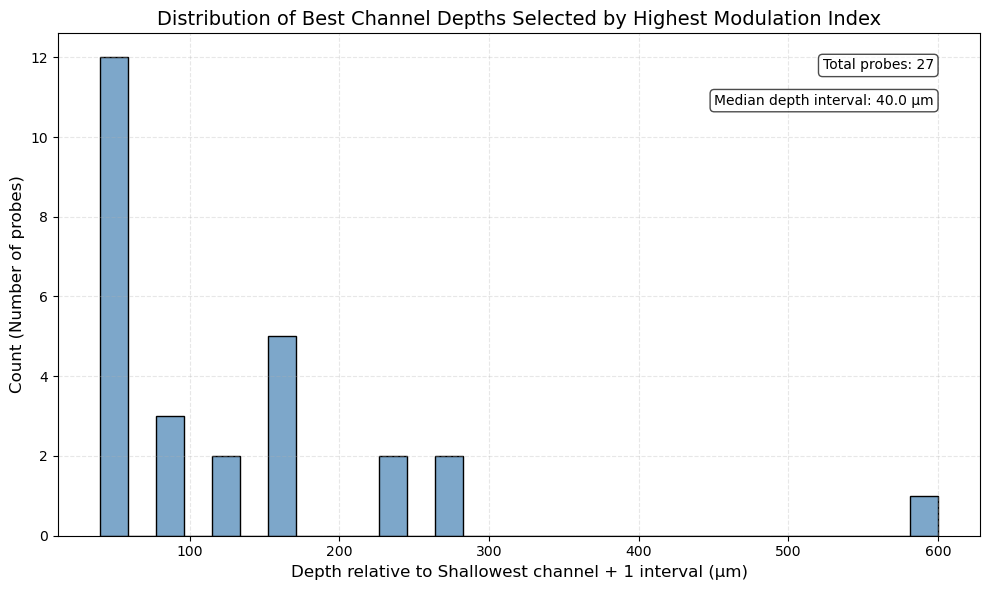

In [33]:
# Step 2: run the plotting function on all sessions
fig = plot_best_channel_depth_distribution(
    plotter=plotter,
    dataset_name=dataset_name,
    session_ids=session_ids,     # <--- this is the key part
    reference_point='top',        # or 'center'
    figsize=(10, 6)
)

plt.show()